In [156]:
import pandas as pd

# Charger un fichier CSV situé dans le même répertoire que le notebook
df = pd.read_csv('../data/data.csv', sep=';')

In [157]:
df_filter = df[df['code_insee_region']==32]  [['date_heure','date','heure','consommation_brute_electricite_rte']]

In [158]:
df_filter['date_heure'] = pd.to_datetime(df_filter['date_heure'], utc=True)

In [159]:
df_filter.to_csv("../data/hdf_dataset.csv")

In [160]:
df = pd.read_csv('../data/hdf_dataset.csv', index_col="date_heure", parse_dates = True)

In [162]:
df = df.drop(columns=["Unnamed: 0",'heure','date'])

KeyError: "['Unnamed: 0', 'heure', 'date'] not found in axis"

In [155]:
df.index = pd.to_datetime(df.index)

# Convertir l'index en temps universel coordonné (UTC)
df.index = df.index.tz_convert('UTC')

ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True

In [163]:
df

,consommation_brute_electricite_rte
date_heure,
2013-01-21 10:00:00+00:00,8514
2013-01-21 18:00:00+00:00,8797
2013-01-21 19:00:00+00:00,8567
2013-01-21 20:00:00+00:00,8009
2013-01-21 22:00:00+00:00,7541
...,...
2023-06-23 05:30:00+00:00,5940
2023-06-23 08:00:00+00:00,5095
2023-06-23 09:30:00+00:00,4983


In [165]:
df_daily = df["consommation_brute_electricite_rte"].resample('D').mean()

In [122]:
df_daily.to_csv("../data/hdf_daily.csv")

In [85]:
# preparation d un df pour prophet
df_prophet = pd.read_csv("../data/hdf_dataset.csv")

df_prophet = df_prophet.drop(columns=["Unnamed: 0", "date_heure", "heure"])

df_prophet = df_prophet.groupby('date')['consommation_brute_electricite_rte'].mean().reset_index()

In [87]:
df_prophet

,date,consommation_brute_electricite_rte
0,2013-01-01,5400.617021
1,2013-01-02,6428.812500
2,2013-01-03,6664.750000
3,2013-01-04,6666.875000
4,2013-01-05,6213.104167
...,...,...
3828,2023-06-26,4575.020833
3829,2023-06-27,4620.229167
3830,2023-06-28,4764.916667
3831,2023-06-29,4813.354167


<Axes: xlabel='date_heure'>

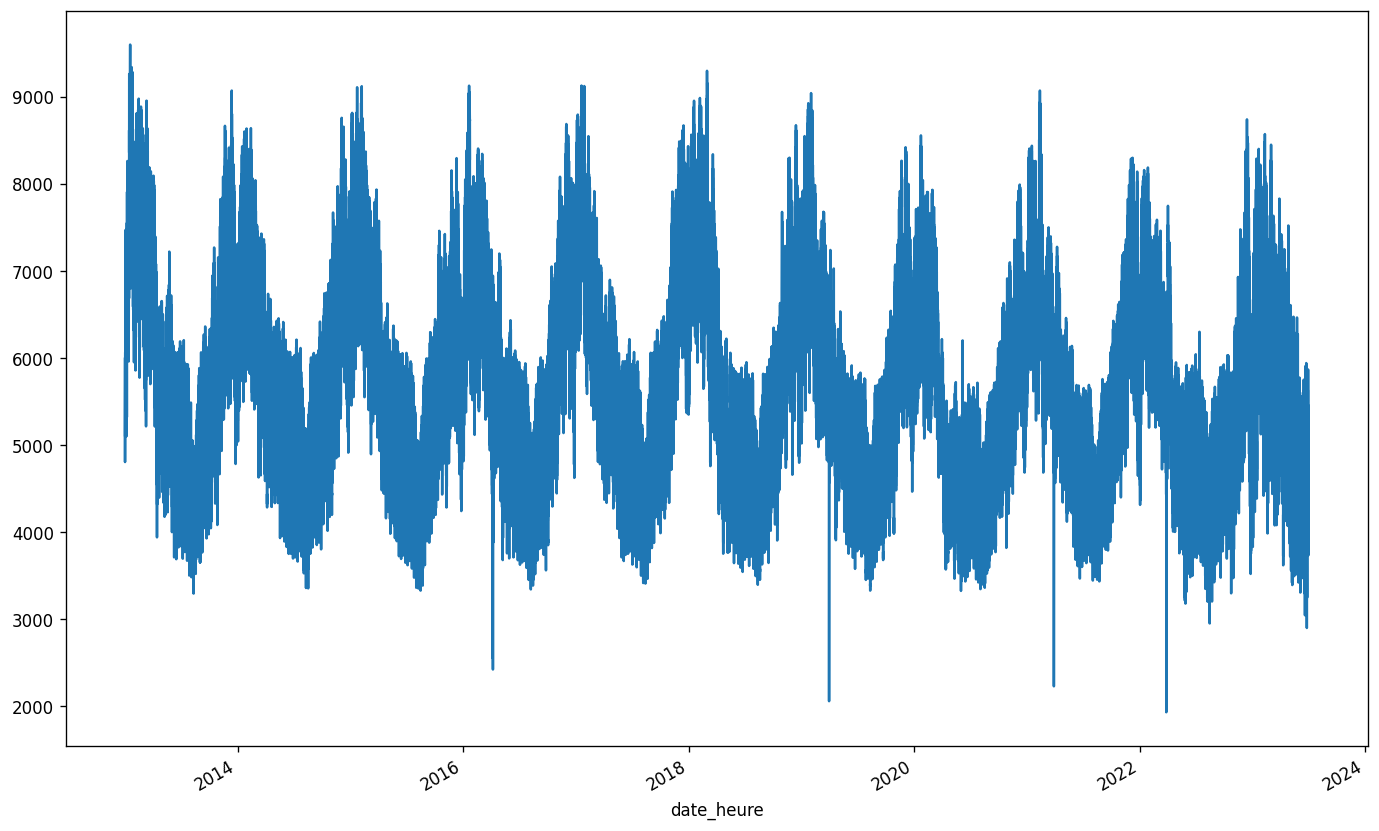

In [7]:
df["consommation_brute_electricite_rte"].plot()

In [8]:
df

,date,heure,consommation_brute_electricite_rte
date_heure,,,
2013-01-21 10:00:00+00:00,2013-01-21,11:00,8514
2013-01-21 18:00:00+00:00,2013-01-21,19:00,8797
2013-01-21 19:00:00+00:00,2013-01-21,20:00,8567
2013-01-21 20:00:00+00:00,2013-01-21,21:00,8009
2013-01-21 22:00:00+00:00,2013-01-21,23:00,7541
...,...,...,...
2023-06-23 05:30:00+00:00,2023-06-23,07:30,5940
2023-06-23 08:00:00+00:00,2023-06-23,10:00,5095
2023-06-23 09:30:00+00:00,2023-06-23,11:30,4983


## Approche statistique avec statmodels

### 1. Sachant que les modèles ARIMA et SARIMA sont des régression linéaires qui prennent comme variables explicatives les “lags” (les états précédents) de notre time série. Pourquoi est-on si attaché au fait que notre série temporelle soit stationnaire?

La time serie doit etre stationnaire :

- Prévisibilité des relations : Les modèles ARIMA et SARIMA supposent que les relations entre les valeurs de la série temporelle (lags) sont constantes dans le temps. Cela signifie que la relation entre une valeur à un moment donné et les valeurs passées doit rester constante. Dans une série non stationnaire, ces relations peuvent changer au fil du temps, ce qui rend la modélisation difficile.

- Stabilité des paramètres : Les modèles ARIMA et SARIMA estiment des paramètres (coefficients) pour les lags de la série temporelle. Pour que ces estimations soient fiables, il est important que les paramètres soient stables au fil du temps. Dans une série stationnaire, les paramètres sont plus susceptibles de rester stables, ce qui facilite l'estimation et l'interprétation des modèles.

- Prévisions fiables : L'objectif principal de la modélisation de séries temporelles est généralement de faire des prévisions futures. Les modèles ARIMA et SARIMA sont conçus pour être utilisés dans des séries stationnaires, car ils supposent que les tendances et les motifs saisonniers ont été supprimés. Cela permet de faire des prévisions plus fiables en supprimant les variations systématiques de la série.

### 2. Qu’est qu’un modèle AR, à quoi correspond le paramètre p ?

Un modèle AR (Auto-Regressive) est un modèle de série temporelle qui modélise la relation entre une observation actuelle et un ensemble d'observations passées (appelées lags ou retards) de la série temporelle. Le paramètre "p" dans un modèle AR, noté AR(p), représente l'ordre du modèle, c'est-à-dire le nombre de lags ou de retards inclus dans le modèle pour prédire la valeur actuelle.  
Plus "p" est élevé, plus le modèle inclura de valeurs passées pour prédire la valeur actuelle. Cependant, il est important de choisir judicieusement la valeur de "p" en fonction des caractéristiques de la série temporelle, car un "p" trop élevé peut conduire à un surajustement (overfitting) du modèle aux données d'entraînement.  
Le choix de la valeur optimale de "p" peut être déterminé en utilisant des techniques telles que l'analyse des autocorrélations partielles (PACF) ou en ajustant plusieurs modèles AR avec différentes valeurs de "p" et en sélectionnant celui qui donne les meilleures performances sur les données de validation.

### 3. Qu’est ce qu’un modèle MA, à quoi correspond le paramètre q?

Un modèle MA (Moving Average) est un modèle de série temporelle qui modélise la relation entre une observation actuelle et un ensemble d'erreurs (bruit blanc) passées, également appelées innovations, à différents retards (lags). Le paramètre "q" dans un modèle MA, noté MA(q), représente l'ordre du modèle, c'est-à-dire le nombre de retards d'erreurs inclus dans le modèle pour prédire la valeur actuelle.  
Plus "q" est élevé, plus le modèle inclura de retards d'erreurs passées pour prédire la valeur actuelle. Le choix de la valeur optimale de "q" dépend des caractéristiques de la série temporelle et peut être déterminé par des méthodes telles que l'analyse des autocorrélations partielles (PACF) ou par une recherche de modèle basée sur la performance de modèles MA avec différentes valeurs de "q" sur des données de validation.

### 4. Qu’est ce que le modèle ARIMA et à quoi correspond le paramètre d?

Le modèle ARIMA, qui signifie "AutoRegressive Integrated Moving Average", est un modèle de série temporelle largement utilisé pour modéliser et prévoir des séries temporelles prenant en compte la dépendance temporelle, la stationnarité et le bruit. Il combine donc trois composantes : AR (AutoRegressive), I (Integrated), et MA (Moving Average).  
- AR (AutoRegressive) : Cette composante capture la dépendance de la valeur actuelle d'une série temporelle par rapport à ses valeurs passées (appelées lags ou retards). L'ordre de cette composante est spécifié par le paramètre "p". Un modèle AR(p) utilise les p valeurs précédentes pour prédire la valeur actuelle, avec des coefficients AR correspondants.

- I (Integrated) : Cette composante indique le nombre de différenciations nécessaires pour rendre la série temporelle stationnaire, c'est-à-dire pour éliminer les tendances et les motifs saisonniers. L'ordre de cette composante est spécifié par le paramètre "d". Si d=0, cela signifie que la série est stationnaire. Si d>0, il s'agit du nombre de différenciations requises pour obtenir la stationnarité.

- MA (Moving Average) : Cette composante capture la dépendance de la valeur actuelle d'une série temporelle par rapport à des erreurs (bruit blanc) passées à différents retards (lags). L'ordre de cette composante est spécifié par le paramètre "q". Un modèle MA(q) utilise les q erreurs précédentes pour prédire la valeur actuelle, avec des coefficients MA correspondants.  


### 5. Qu’est ce que le modèle SARIMA et à quoi correspond le paramètre s?

Le modèle SARIMA, qui signifie "Seasonal AutoRegressive Integrated Moving Average", est une extension du modèle ARIMA conçu pour prendre en compte les composantes saisonnières dans les séries temporelles. Le paramètre "s" dans un modèle SARIMA correspond à la période de saisonnalité, c'est-à-dire le nombre d'observations par période saisonnière et permet au modèle de prendre en compte les motifs saisonniers qui se répètent à chaque saison. En spécifiant correctement "s", le modèle peut mieux modéliser les fluctuations saisonnières dans les données. 
- AR (AutoRegressive) : Comme dans un modèle ARIMA, la composante AR capture la dépendance de la valeur actuelle par rapport à ses valeurs passées (lags). L'ordre de cette composante est spécifié par le paramètre "p".

- I (Integrated) : Tout comme dans un modèle ARIMA, la composante I indique le nombre de différenciations nécessaires pour rendre la série temporelle stationnaire. L'ordre de cette composante est spécifié par le paramètre "d".

- MA (Moving Average) : La composante MA capture la dépendance de la valeur actuelle par rapport à des erreurs (bruit blanc) passées à différents retards (lags). L'ordre de cette composante est spécifié par le paramètre "q".

- S (Seasonal) : Cette composante spécifie la période de saisonnalité de la série temporelle. Le paramètre "s" indique combien d'observations constituent une saison complète. Par exemple, si vous avez des données mensuelles et qu'il y a une saisonnalité annuelle, "s" serait égal à 12. Cela signifie qu'il y a 12 mois dans une saison complète.  


### 6. Déterminer les paramètres s, d, q, p  à l’aide des graphiques d’autocorrélation et d’autocorrélation partielle, ainsi qu’à l’aide des graphiques de la première partie.
Déterminer d’abord s et appliquer la désaisonnalisation  
Sur la série désaisonnalisée recherchez d et détrendez  
Sur la série détrendée, recherchez q et p

/tmp/ipykernel_213106/1424297624.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(df_aggregated, lags=50).show()


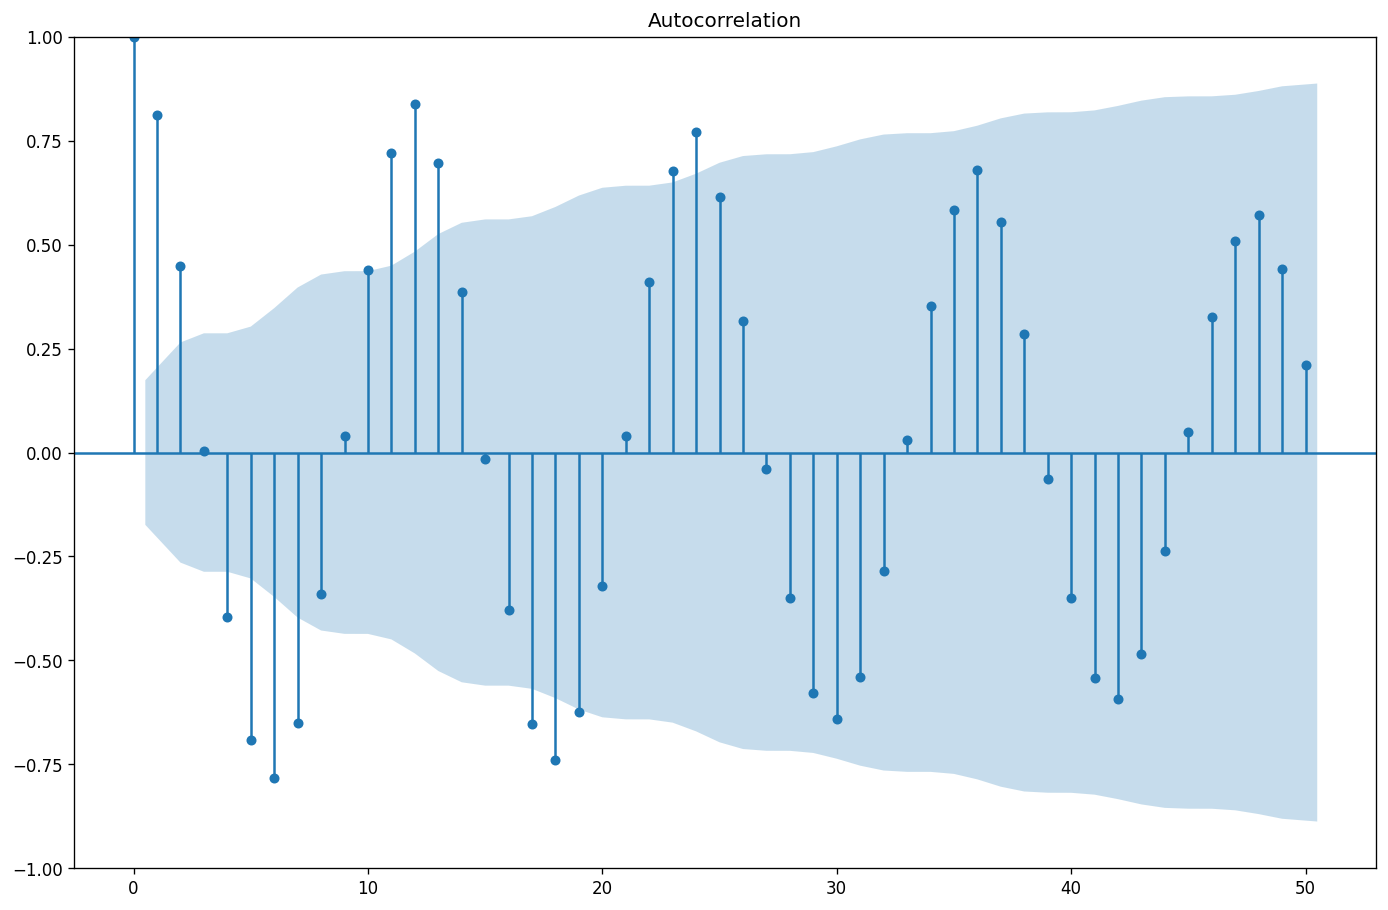

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

df_aggregated = df["consommation_brute_electricite_rte"].resample('M').mean()

# Tracez l'autocorrélation de la série temporelle sur un nombre de lags raisonnable
plot_acf(df_aggregated, lags=50).show()

/tmp/ipykernel_213106/4038426023.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(df_aggregated, lags=150).show()


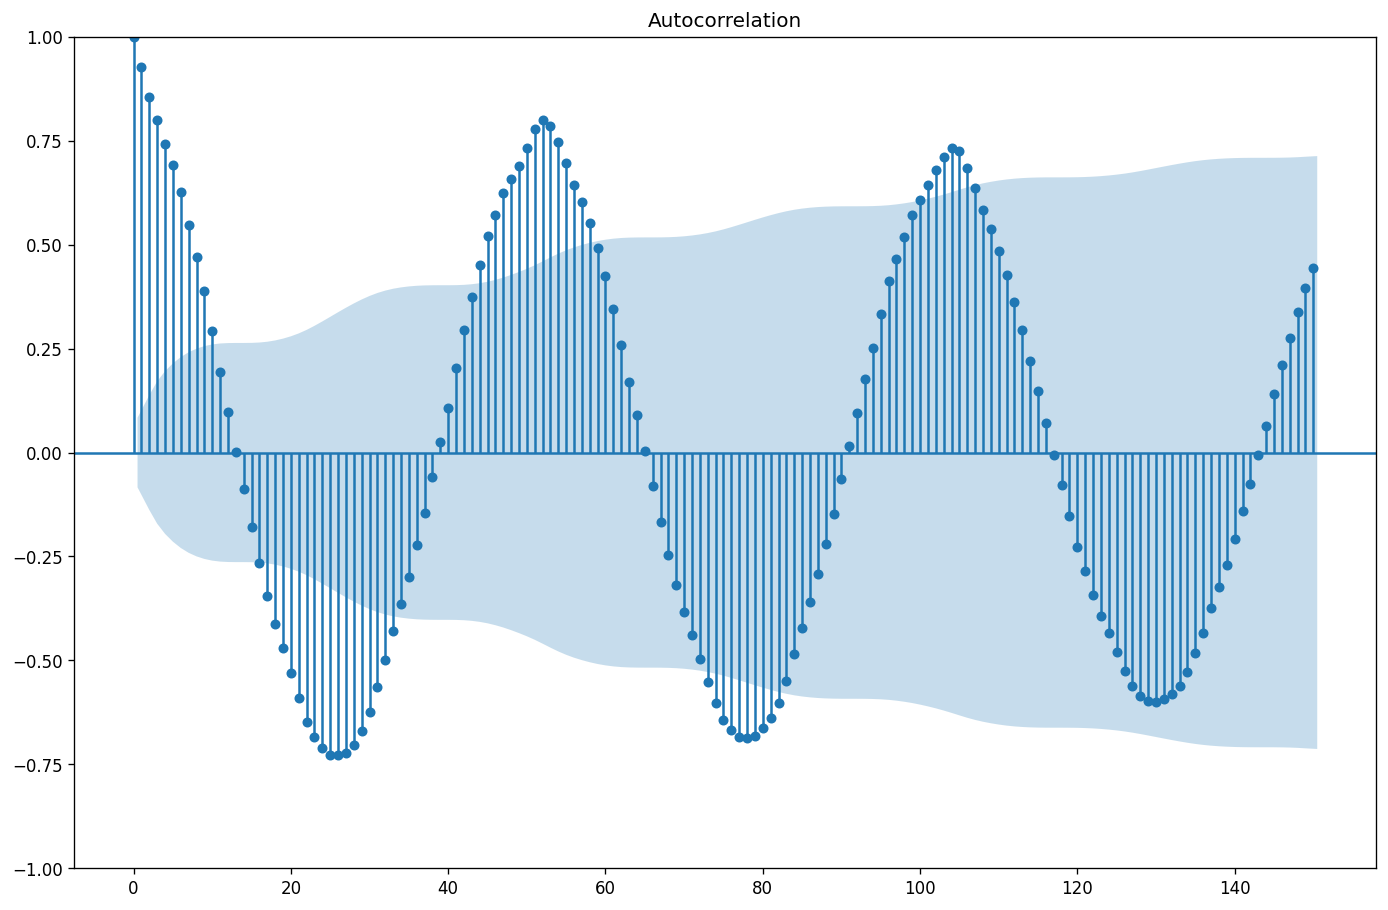

In [10]:
df_aggregated = df["consommation_brute_electricite_rte"].resample('W').mean()

# Tracez l'autocorrélation de la série temporelle sur un nombre de lags raisonnable
plot_acf(df_aggregated, lags=150).show()


/tmp/ipykernel_213106/2868580697.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(df_aggregated, lags=700).show()


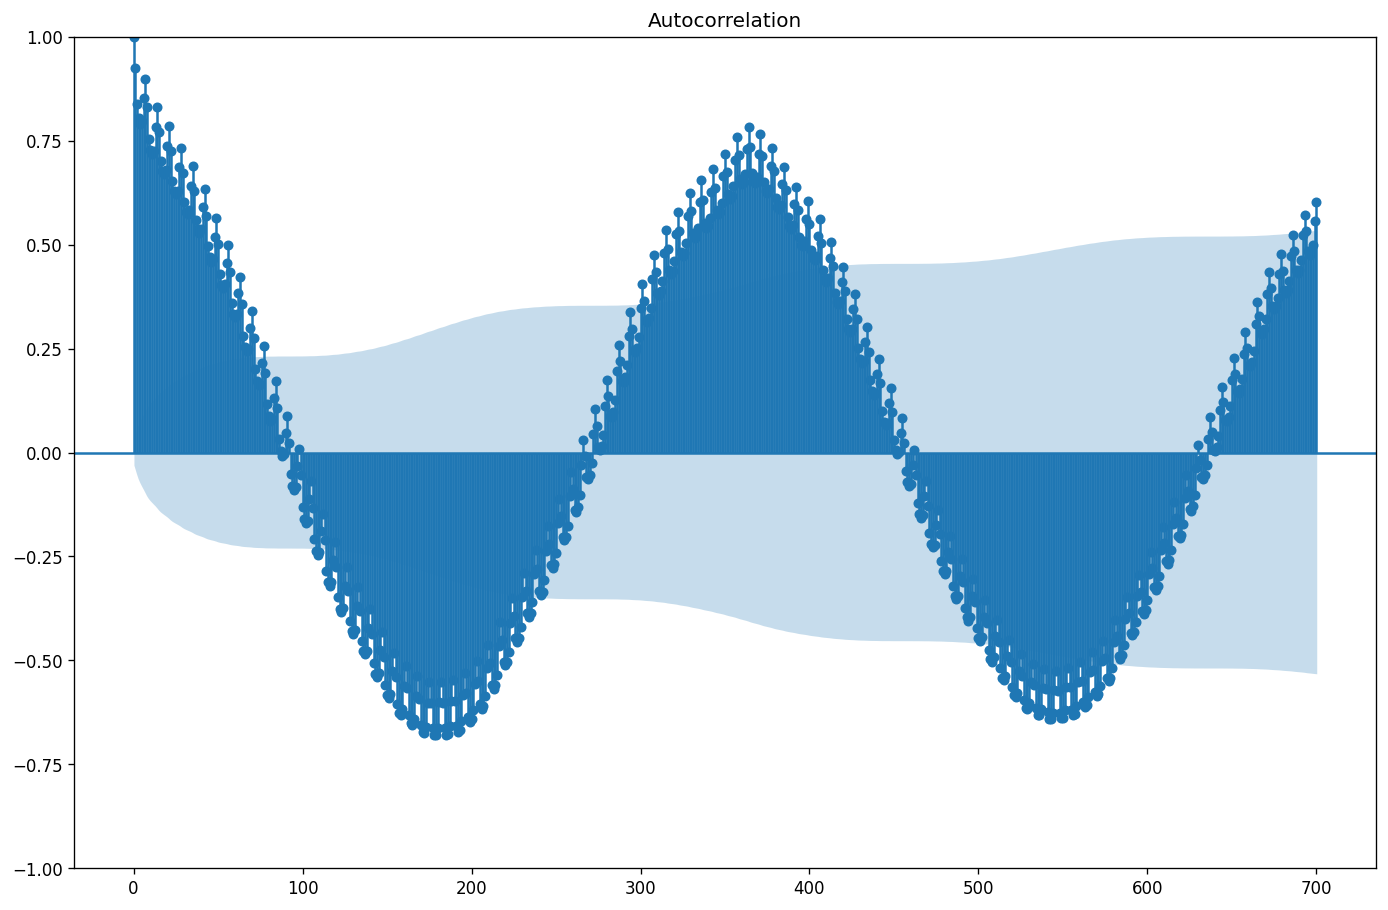

In [11]:
df_aggregated = df["consommation_brute_electricite_rte"].resample('D').mean()

# Tracez l'autocorrélation de la série temporelle sur un nombre de lags raisonnable
plot_acf(df_aggregated, lags=700).show()


/home/apprenant/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/tmp/ipykernel_213106/1908237841.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(df_rolling_mean,ax=axes[0, 2]).show()
/tmp/ipykernel_213106/1908237841.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(df_rolling_mean.diff().dropna(),ax=axes[1, 2]).show()
/tmp/ipykernel_213106/1908237841.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(df_rolling_mean.diff().diff().dropna(),ax=axes[2, 2]).show()


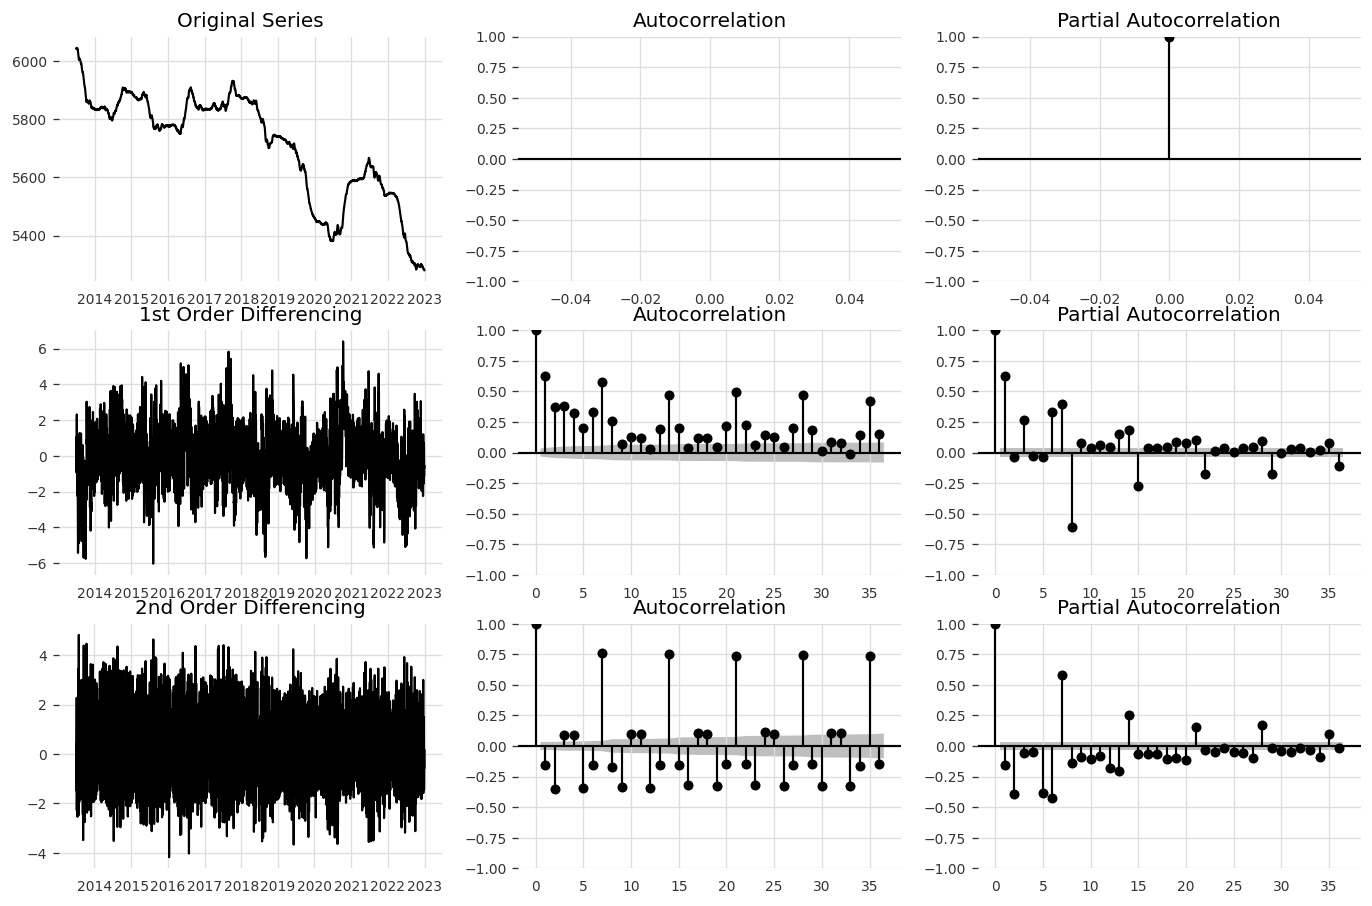

In [50]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(14,9), 'figure.dpi':120})

# df_daily = df["consommation_brute_electricite_rte"].resample('D').mean()
df_daily = pd.read_csv('../data/hdf_daily.csv')

# Créer une fenêtre de moyenne mobile sur 365 jours
# rolling_window = df_daily.rolling(window=365, center=True, min_periods=1, win_type=None)
df_rolling = df_daily.rolling(window=365, center=True, win_type=None)

# Calculer la moyenne mobile sur 365 jours
df_rolling_mean = df_rolling.mean()

# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(df_rolling_mean); axes[0, 0].set_title('Original Series')
plot_acf(df_rolling_mean, ax=axes[0, 1])
plot_pacf(df_rolling_mean,ax=axes[0, 2]).show()

# 1st Differencing
axes[1, 0].plot(df_rolling_mean.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_rolling_mean.diff().dropna(), ax=axes[1, 1])
plot_pacf(df_rolling_mean.diff().dropna(),ax=axes[1, 2]).show()

# 2nd Differencing
axes[2, 0].plot(df_rolling_mean.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_rolling_mean.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(df_rolling_mean.diff().diff().dropna(),ax=axes[2, 2]).show()

### 7. A l’aide statmodels et dans une approche statistique (sans train/test/split), lancez un modèle ARIMA sur la série désaisonnalisée.  
Est ce que tous les paramètres sont significatifs  
Qu’est ce que l’AIC?  
Essayez d’améliorer votre modèle en modifiant les paramètres non significatifs et en vous basant sur le critère de l’AIC.

<Axes: xlabel='date_heure'>

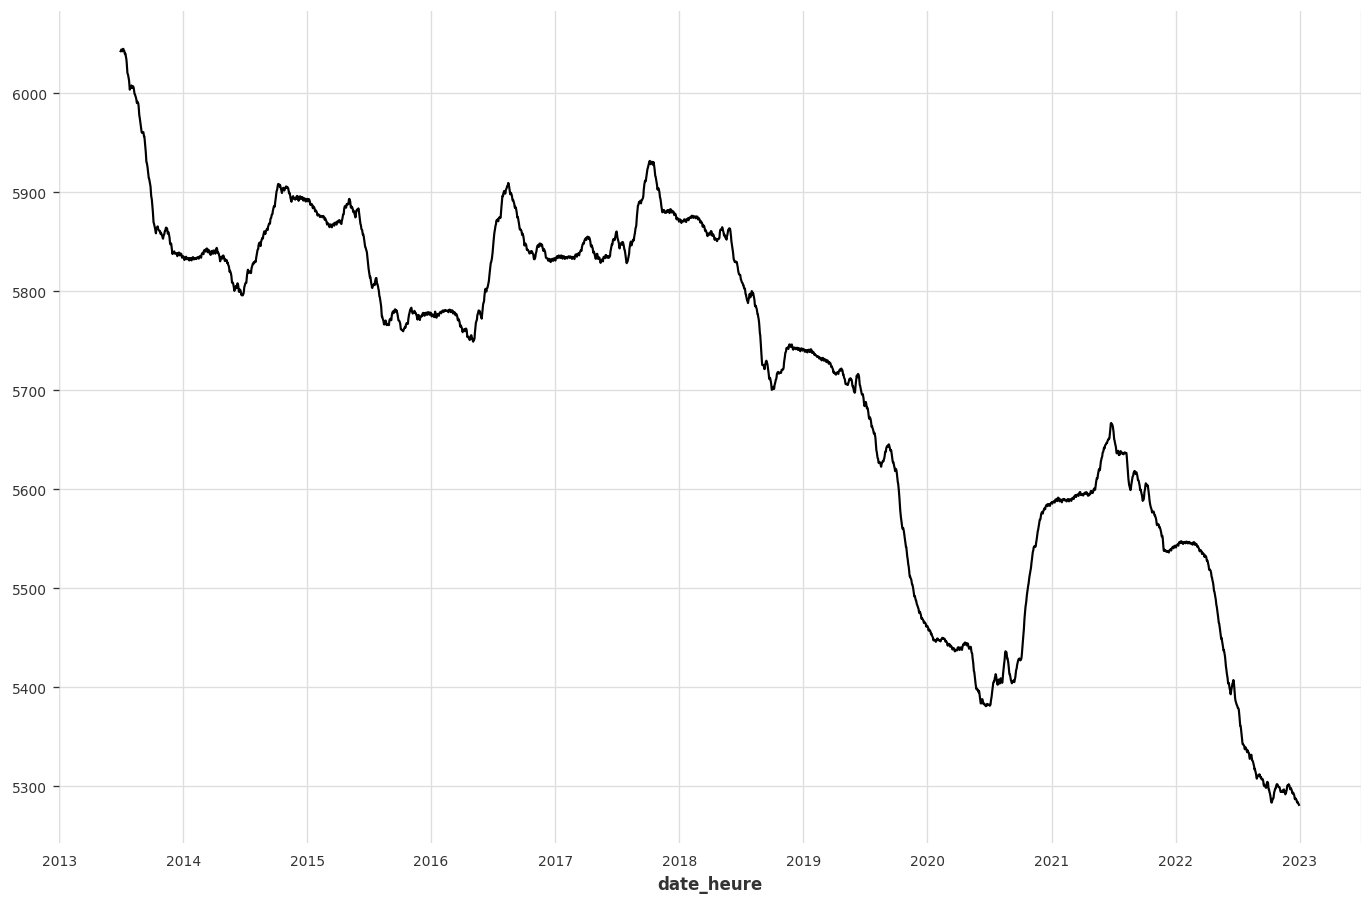

In [51]:
df_rolling_mean.plot()

In [57]:
import statsmodels.api as sm

# Créez un modèle ARIMA avec des ordres p, d et q appropriés
p = 1  # Ordre AR (AutoRegressive)
d = 0  # Ordre de différenciation (pour la stationnarité)
q = 1  # Ordre MA (Moving Average)

# Créez le modèle ARIMA
model = sm.tsa.ARIMA(df_rolling_mean, order=(p, d, q))

# Ajustez le modèle aux données
results = model.fit()

# Affichez les statistiques du modèle
print(results.summary())

/home/apprenant/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                       SARIMAX Results                                        
Dep. Variable:     consommation_brute_electricite_rte   No. Observations:                 3834
Model:                                 ARIMA(1, 0, 1)   Log Likelihood               -5895.835
Date:                                Mon, 18 Sep 2023   AIC                          11799.669
Time:                                        11:59:45   BIC                          11824.676
Sample:                                    12-31-2012   HQIC                         11808.552
                                         - 06-30-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5707.9959    606.236      9.415      0.000    4519.795    6896.197
ar.

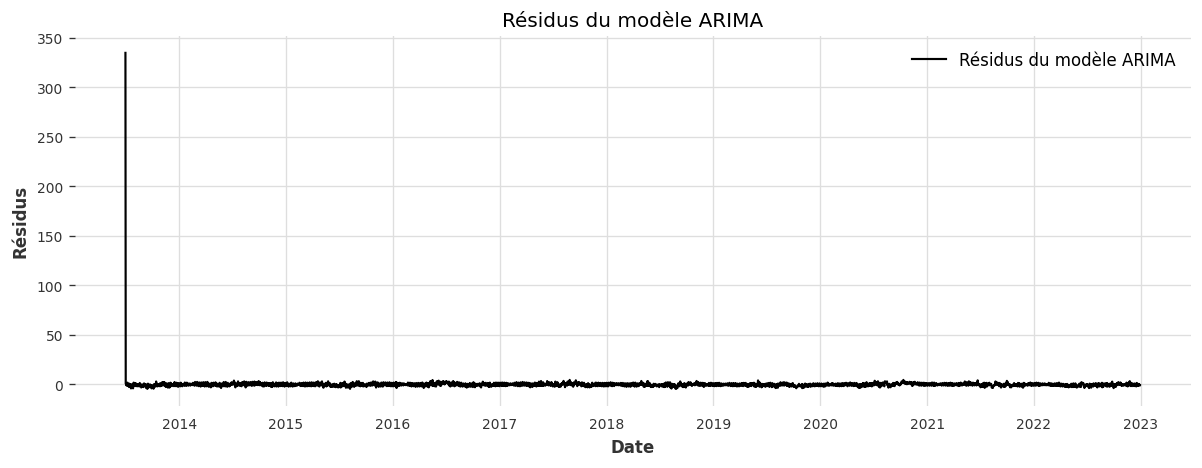

In [59]:
plt.figure(figsize=(12, 4))
plt.plot(results.resid, label='Résidus du modèle ARIMA')
plt.xlabel('Date')
plt.ylabel('Résidus')
plt.legend(loc='best')
plt.title('Résidus du modèle ARIMA')
plt.show()

/tmp/ipykernel_213106/729591740.py:8: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_index = pd.date_range(start=df_rolling_mean.index[-1], periods=n_forecast + 1, closed='right')


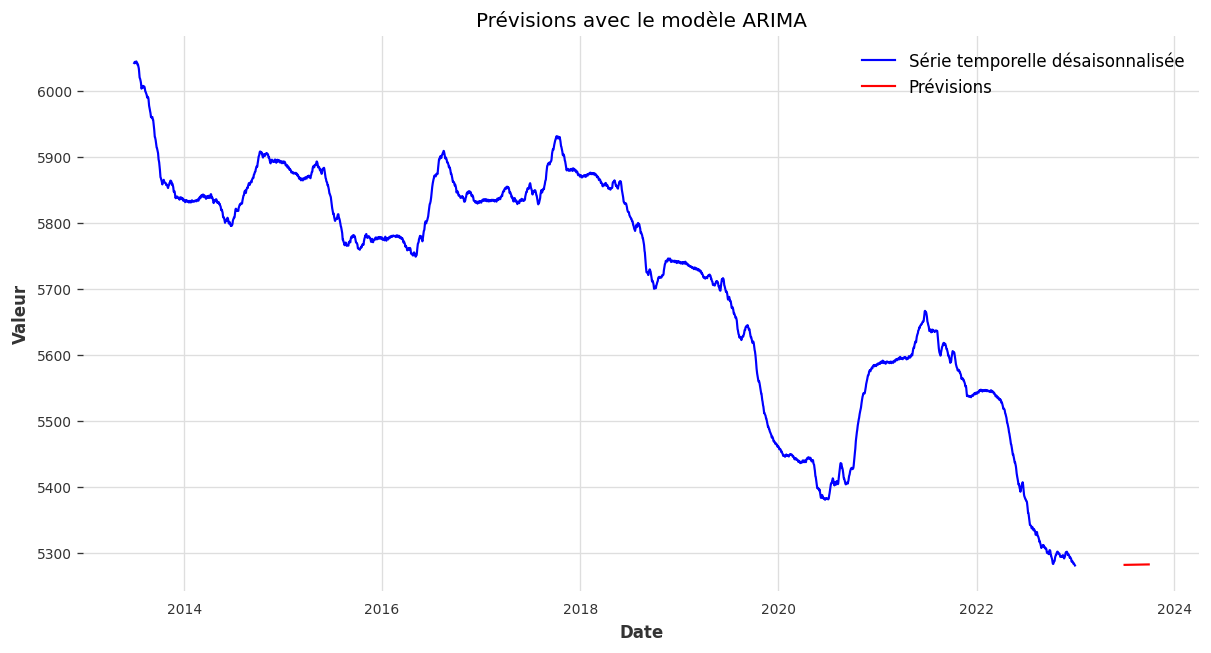

In [63]:
# Nombre de périodes futures à prévoir
n_forecast = 90  # Par exemple, prévoyez 30 périodes futures

# Faites des prévisions
forecast = results.forecast(steps=n_forecast)

# Créez un index pour les prévisions
forecast_index = pd.date_range(start=df_rolling_mean.index[-1], periods=n_forecast + 1, closed='right')

# Créez un DataFrame pour les prévisions
forecast_series = pd.Series(forecast, index=forecast_index)

# Tracer les prévisions
plt.figure(figsize=(12, 6))
plt.plot(df_rolling_mean, label='Série temporelle désaisonnalisée', color='blue')
plt.plot(forecast_series, label='Prévisions', color='red')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend(loc='best')
plt.title('Prévisions avec le modèle ARIMA')
plt.show()


L'AIC (Akaike Information Criterion) est un critère d'évaluation couramment utilisé en statistiques et en modélisation pour comparer la qualité de différents modèles statistiques ou de régression. Il a été développé par le statisticien japonais Hirotugu Akaike. L'AIC est principalement utilisé dans le contexte de la sélection de modèle, où vous avez plusieurs modèles candidats et vous souhaitez déterminer celui qui s'adapte le mieux aux données.

L'AIC est basé sur le principe de la parcimonie, ce qui signifie qu'il préfère les modèles qui ajustent bien les données tout en ayant un nombre minimal de paramètres. L'idée est d'éviter la surajustement (overfitting) en pénalisant les modèles qui ont trop de paramètres.

### AutoARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10042.827, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11908.630, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10380.535, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10522.924, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11936.215, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10121.373, Time=1.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10170.859, Time=0.96 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9075.701, Time=4.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10146.800, Time=0.85 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.00 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8998.572, Time=5.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10148.334, Time=9.52 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=11.53 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=13.55 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   :

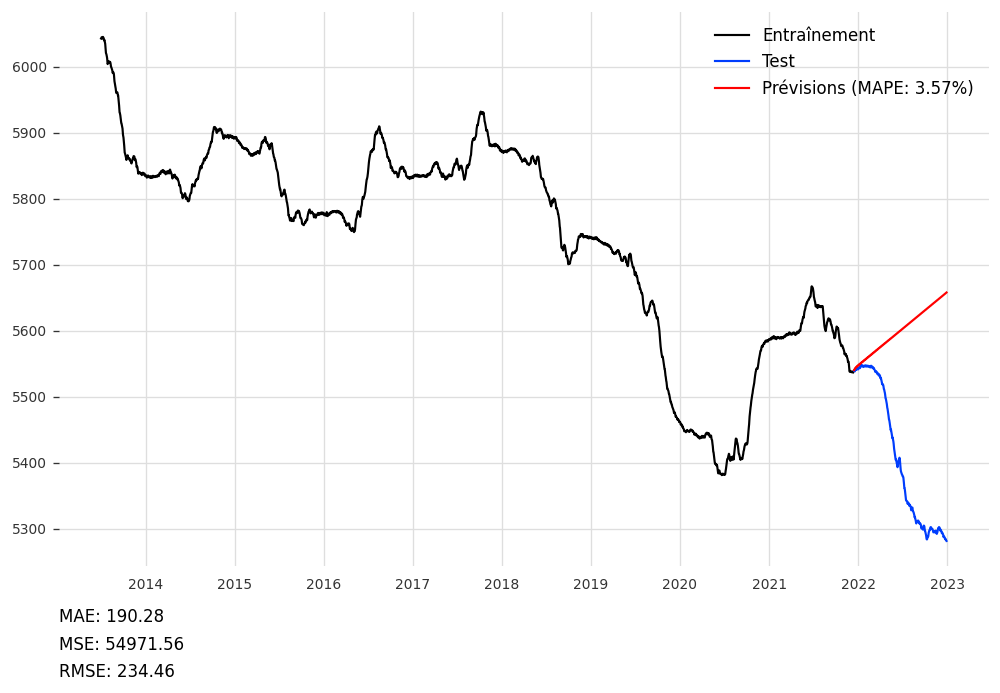

In [ ]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

df_diff = df_rolling_mean.dropna()

# Séparation en données d'entraînement et de test
training = df_diff.iloc[:-380]
test = df_diff.iloc[-380:]

# Utilisation de auto_arima pour trouver le meilleur modèle ARIMA
model = auto_arima(training, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(training)

# Faire une prévision
forecast = model.predict(n_periods=len(test))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculez le MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculez les erreurs
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

# Afficher la prévision
plt.figure(figsize=(10, 6))
plt.plot(training.index, training, label="Entraînement")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label=f'Prévisions (MAPE: {mape:.2f}%)', color='red')
plt.legend(loc='best')
leg = plt.gca().get_legend()
ltext = leg.get_texts()[0] # Obtenez le texte de la légende pour avoir sa position
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.15, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)
plt.show()

/home/apprenant/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/apprenant/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/apprenant/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


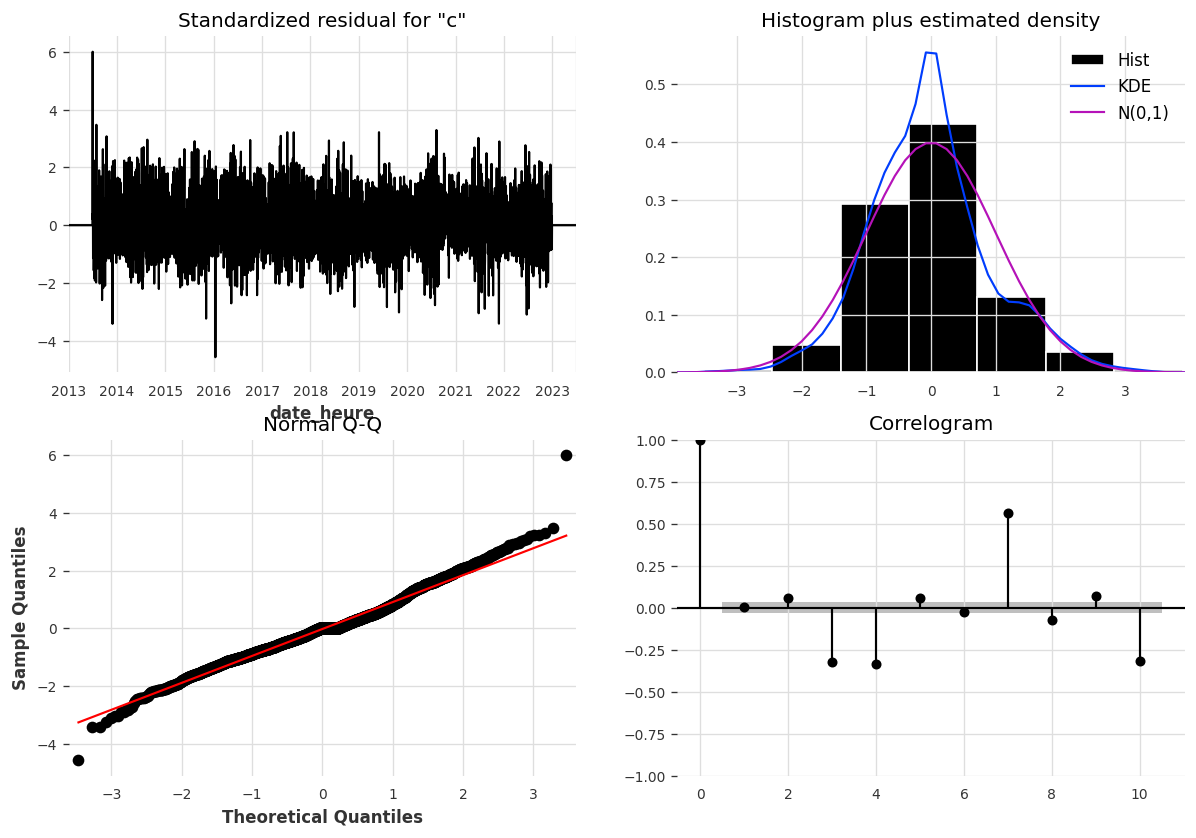

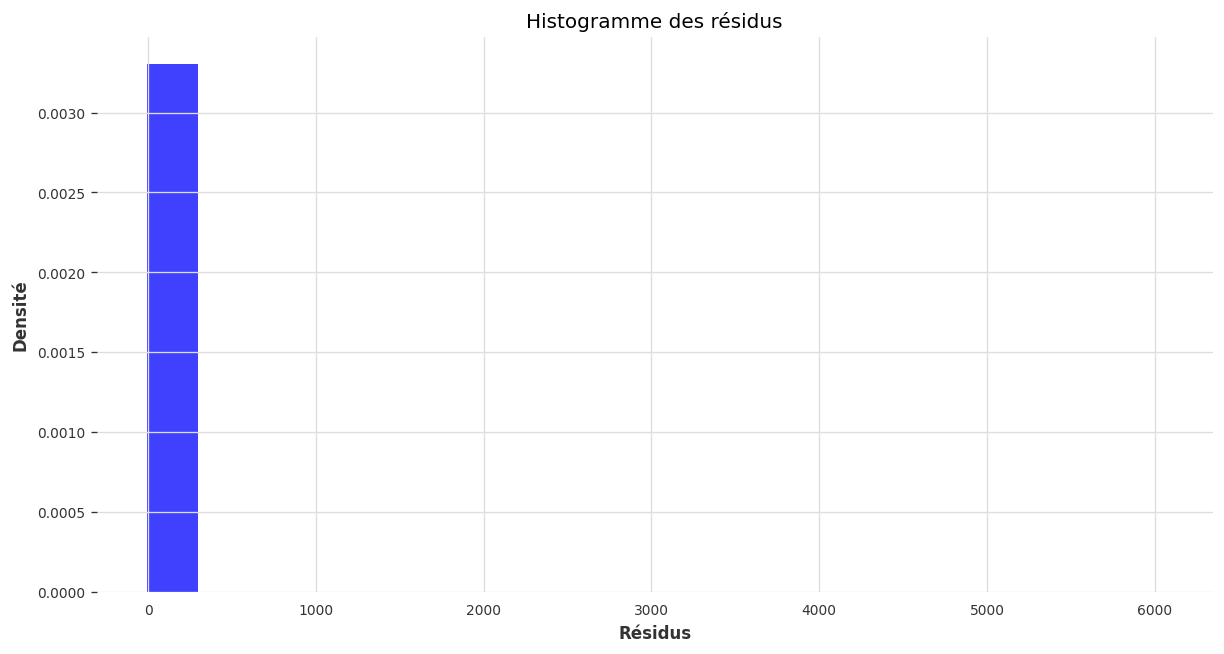

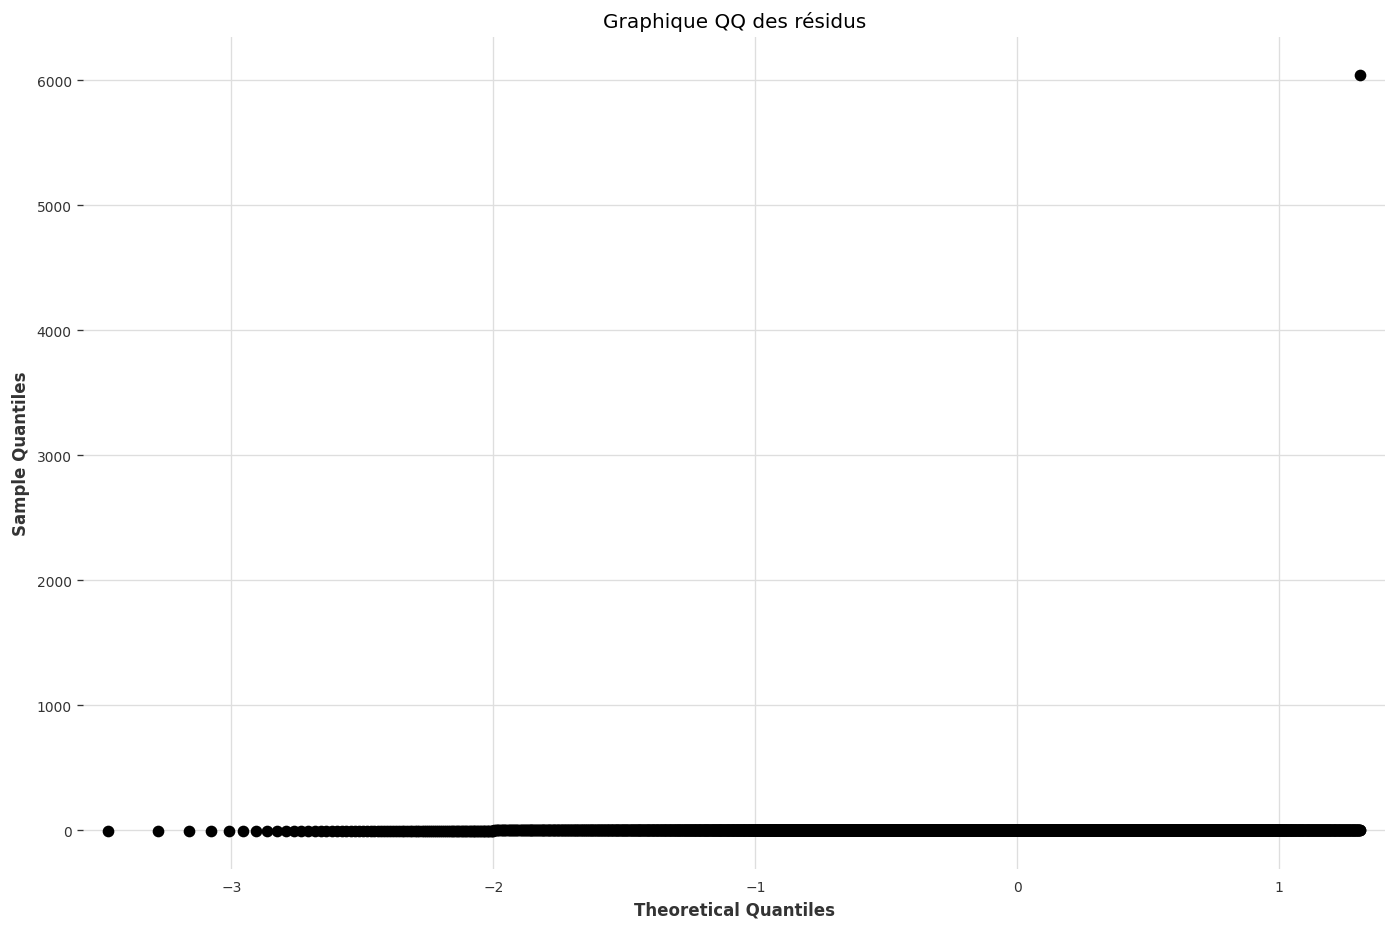

/home/apprenant/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


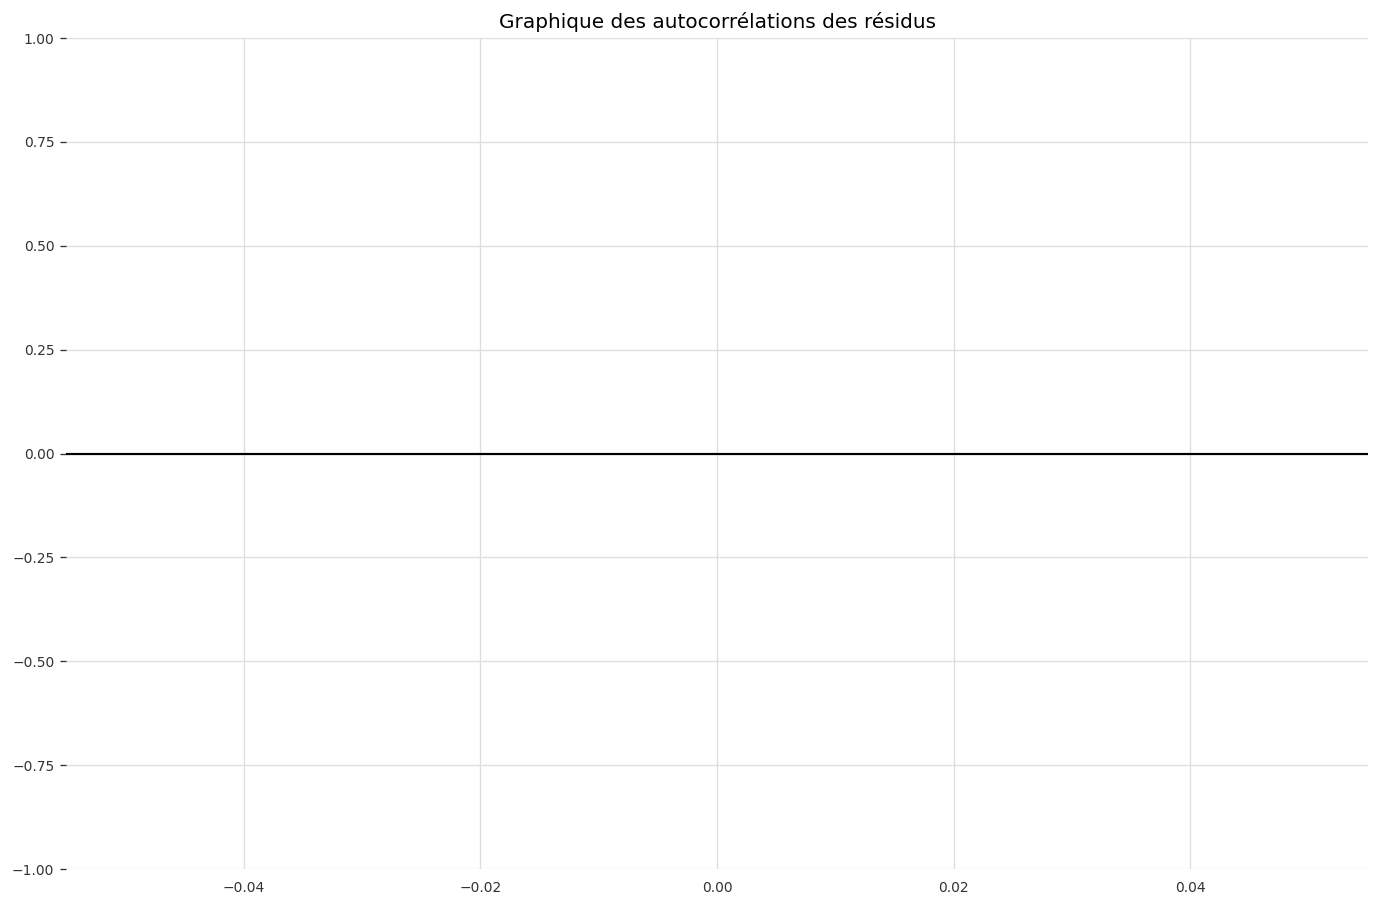

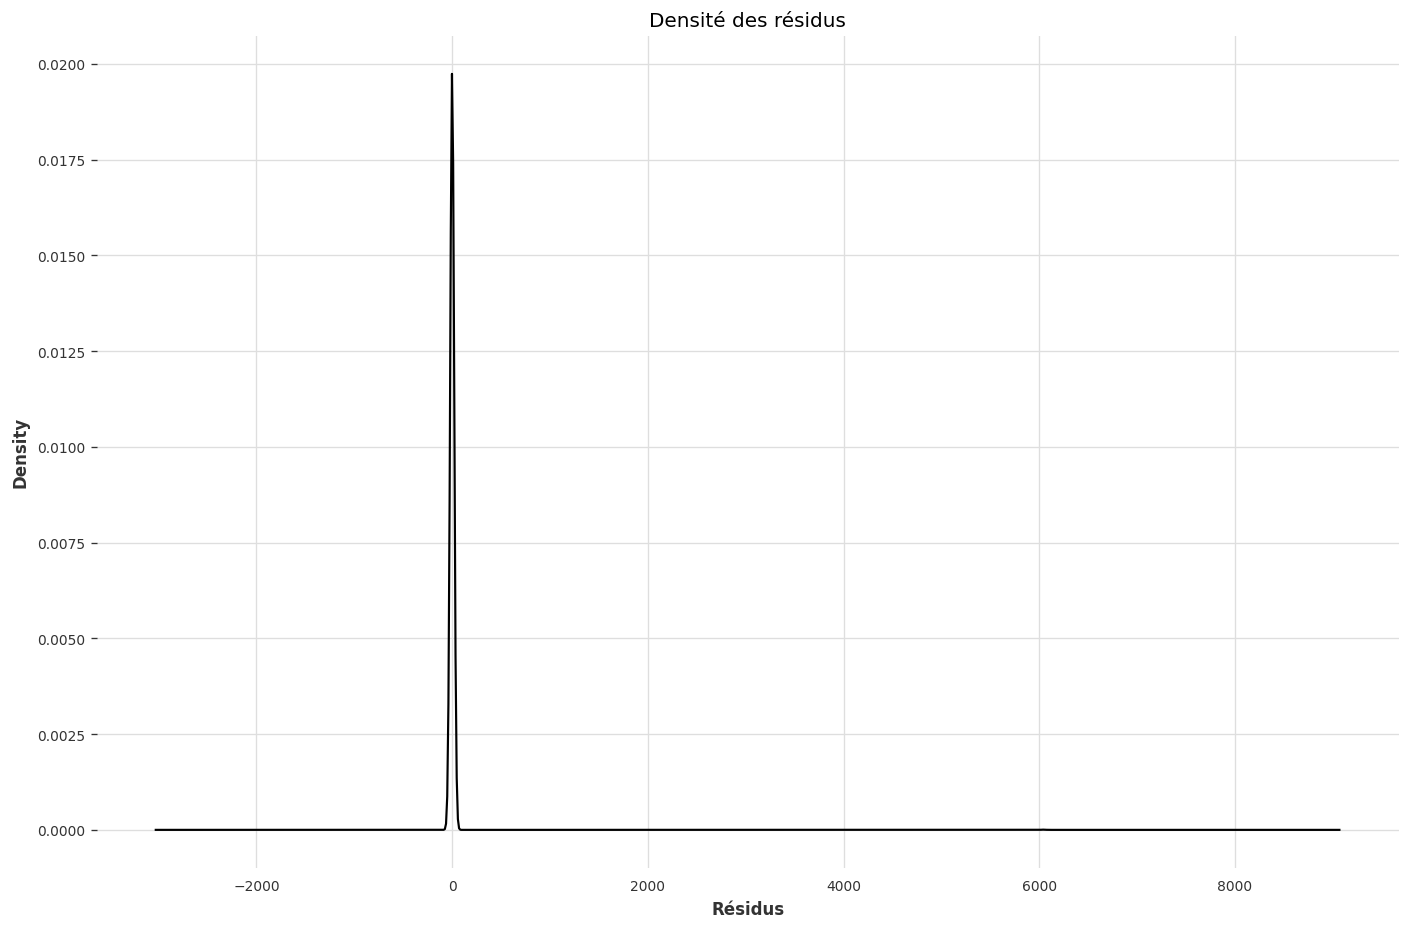

In [66]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Chargez votre série temporelle
# ...

# Ajustez un modèle ARIMA
p = 3  # Ordre AR
d = 1  # Ordre de différenciation
q = 3  # Ordre MA
model = sm.tsa.ARIMA(df_rolling_mean, order=(p, d, q))
results = model.fit()

# Affichez les résidus
residuals = results.resid

# Affichez les diagnostics du modèle
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Tracez l'histogramme des résidus
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=20, density=True, alpha=0.75, color='blue')
plt.title('Histogramme des résidus')
plt.xlabel('Résidus')
plt.ylabel('Densité')
plt.show()

# Tracez le graphique QQ des résidus
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='s')
plt.title('Graphique QQ des résidus')
plt.show()

# Tracez le graphique des autocorrélations des résidus
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=20)
plt.title('Graphique des autocorrélations des résidus')
plt.show()

# Tracez le graphique de la densité des résidus
residuals.plot(kind='kde')
plt.title('Densité des résidus')
plt.xlabel('Résidus')
plt.show()


### 9. Affichez les prédictions du meilleur de vos modèles. Qu’en pensez vous?

### SARIMAX

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42902D+00    |proj g|=  3.74907D-01

At iterate    5    f=  1.20297D+00    |proj g|=  8.40871D-02

At iterate   10    f=  1.09881D+00    |proj g|=  3.74519D-02

At iterate   15    f=  1.06139D+00    |proj g|=  2.77362D-02

At iterate   20    f=  1.05611D+00    |proj g|=  7.87786D-03

At iterate   25    f=  1.05106D+00    |proj g|=  1.23404D-02

At iterate   30    f=  1.04867D+00    |proj g|=  1.13678D-02

At iterate   35    f=  1.04821D+00    |proj g|=  5.06819D-04

At iterate   40    f=  1.04819D+00    |proj g|=  2.16842D-03

At iterate   45    f=  1.04813D+00    |proj g|=  4.08347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

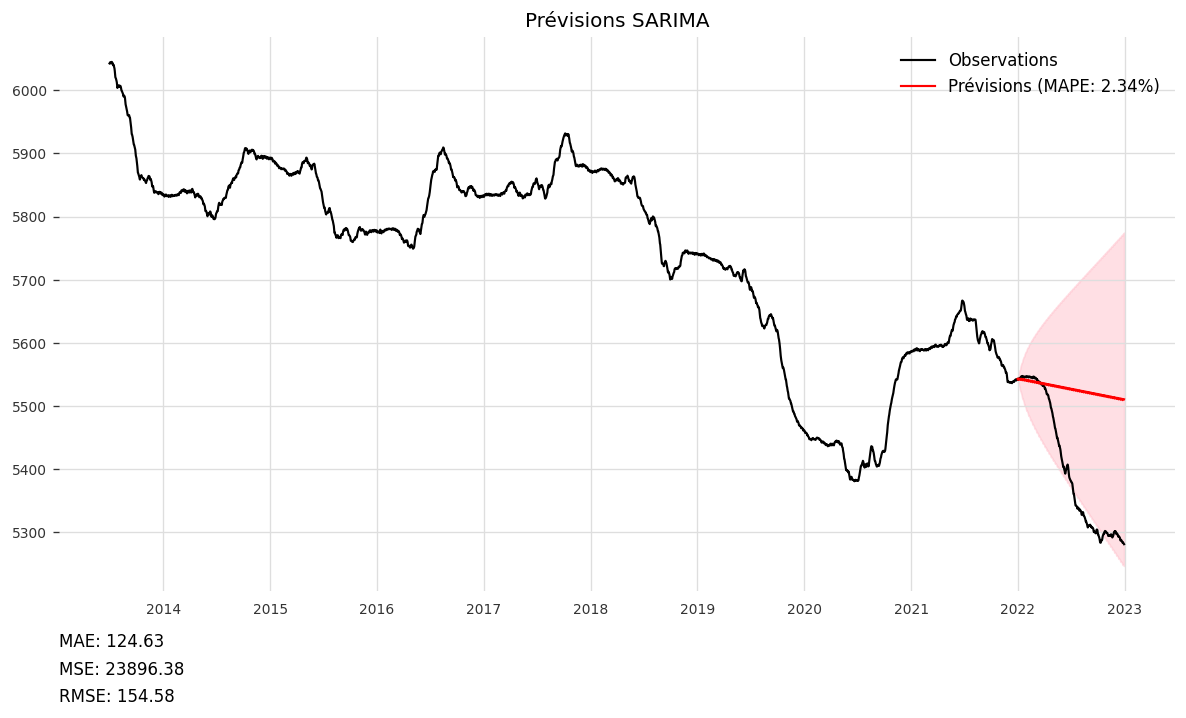

In [67]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Différenciez la série temporelle
df_diff = df_rolling_mean.dropna()

# Séparation en données d'entraînement et de test
training = df_diff.iloc[:-365]
test = df_diff.iloc[-365:]

p = 1  # Ordre AR
d = 1  # Ordre de différenciation
q = 3  # Ordre MA
s = 7 # Période saisonnière

P = 1
D = 0
Q = 3

model = sm.tsa.SARIMAX(training, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

forecast_steps = len(test)  # Par exemple, prévoir les prochaines 7 périodes
forecast = results.get_forecast(steps=forecast_steps)

# Obtenez les prévisions et les intervalles de confiance
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculez le MAPE
mape = mean_absolute_percentage_error(test, forecast_mean)

# Calculez les erreurs
mae = mean_absolute_error(test, forecast_mean)
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)

# Tracez les prévisions et les intervalles de confiance
plt.figure(figsize=(12, 6))
plt.plot(df_diff.index, df_diff, label='Observations', color='black')
plt.plot(forecast_mean.index, forecast_mean, label=f'Prévisions (MAPE: {mape:.2f}%)', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend(loc='upper right')
leg = plt.gca().get_legend()
ltext = leg.get_texts()[0] # Obtenez le texte de la légende pour avoir sa position
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.15, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)
plt.title('Prévisions SARIMA')
plt.show()

### 10. Entrainez le même modèle mais cette fois uniquement sur les dates de 2014 à 2020. Affichez les prédictions sur 2021-2022 et comparez aux valeurs réelles. Comment comprenez-vous la différence entre les deux graphiques?

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8946.004, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10591.456, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9257.128, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9381.244, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10616.542, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9013.783, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9071.404, Time=0.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8921.322, Time=4.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9001.465, Time=1.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8126.115, Time=5.37 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.49 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=8116.361, Time=9.78 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=8788.884, Time=5.42 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC

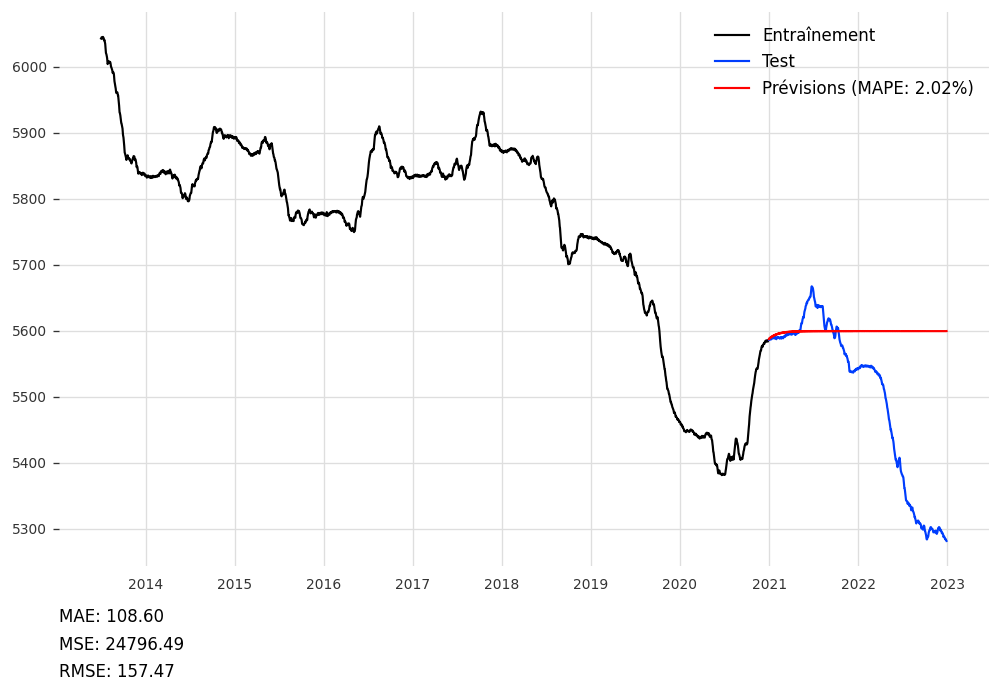

In [73]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

df_diff = df_rolling_mean.dropna()

# Séparation en données d'entraînement et de test
training = df_diff.iloc[:-730]
test = df_diff.iloc[-730:]

# Utilisation de auto_arima pour trouver le meilleur modèle ARIMA
model = auto_arima(training, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(training)

# Faire une prévision
forecast = model.predict(n_periods=len(test))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculez le MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculez les erreurs
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

# Afficher la prévision
plt.figure(figsize=(10, 6))
plt.plot(training.index, training, label="Entraînement")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label=f'Prévisions (MAPE: {mape:.2f}%)', color='red')
plt.legend(loc='best')
leg = plt.gca().get_legend()
ltext = leg.get_texts()[0] # Obtenez le texte de la légende pour avoir sa position
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.15, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)
plt.show()

In [75]:
from pmdarima import auto_arima

# la période saisonnière
s = 7  

# Recherche automatique des ordres SARIMA
model = auto_arima(df_diff, seasonal=True, m=s, trace=True, error_action='ignore', suppress_warnings=True)

# Affichez les ordres optimaux trouvés
print("Ordres optimaux SARIMA:", model.order)
print("Ordres saisonniers optimaux SARIMA:", model.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=23.99 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13317.691, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8873.904, Time=3.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10648.194, Time=2.68 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13376.611, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=11580.373, Time=0.22 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=8308.437, Time=5.12 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=26.14 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=16.73 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=11747.036, Time=3.51 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=8275.503, Time=7.64 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=8825.616, Time=4.60 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=31.32 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=19.38 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=8276.7

/home/apprenant/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/apprenant/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68211D+00    |proj g|=  8.22901D-01

At iterate    5    f=  1.18757D+00    |proj g|=  2.71231D-02

At iterate   10    f=  1.18146D+00    |proj g|=  7.81733D-03

At iterate   15    f=  1.18128D+00    |proj g|=  1.09704D-02

At iterate   20    f=  1.17977D+00    |proj g|=  1.44419D-02

At iterate   25    f=  1.17207D+00    |proj g|=  5.60107D-02

At iterate   30    f=  1.16514D+00    |proj g|=  8.04244D-03

At iterate   35    f=  1.16434D+00    |proj g|=  1.58204D-03

At iterate   40    f=  1.16430D+00    |proj g|=  6.49636D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

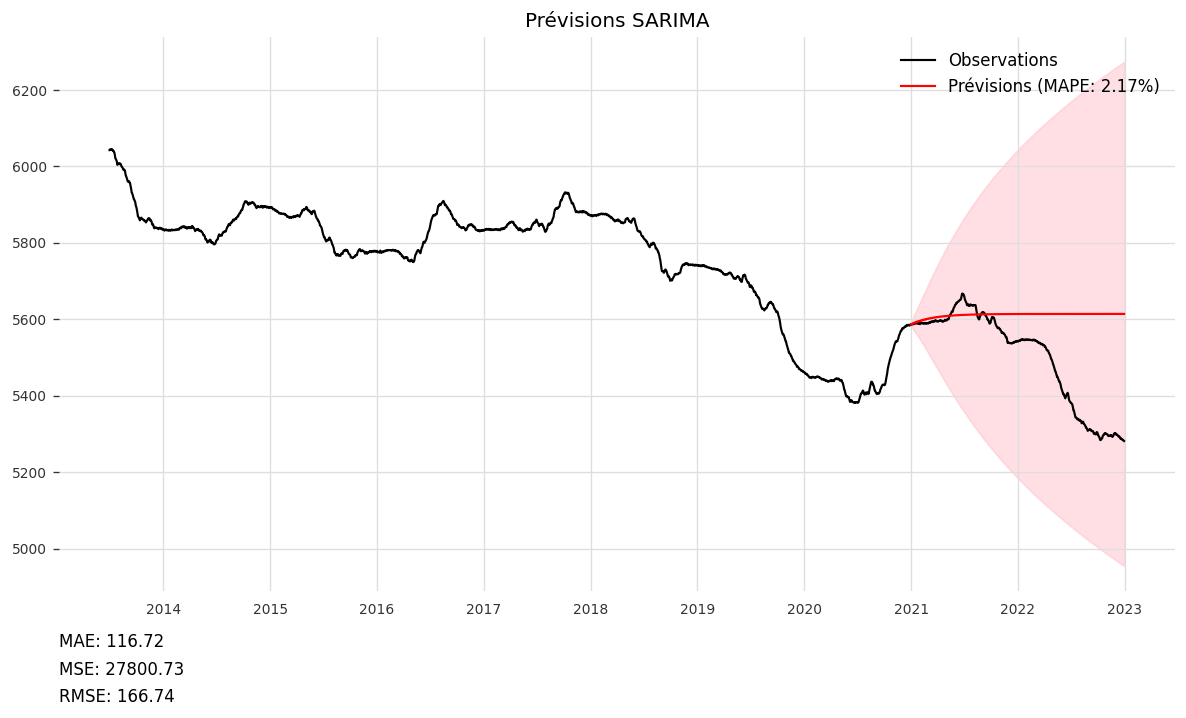

In [76]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Différenciez la série temporelle
df_diff = df_rolling_mean.dropna()

# Séparation en données d'entraînement et de test
training = df_diff.iloc[:-730]
test = df_diff.iloc[-730:]

# ARIMA(2,1,1)(2,0,0)[7]

p = 2  # Ordre AR
d = 1  # Ordre de différenciation
q = 1  # Ordre MA
s = 7 # Période saisonnière

P = 2
D = 0
Q = 0

model = sm.tsa.SARIMAX(training, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

forecast_steps = len(test)  # Par exemple, prévoir les prochaines 7 périodes
forecast = results.get_forecast(steps=forecast_steps)

# Obtenez les prévisions et les intervalles de confiance
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculez le MAPE
mape = mean_absolute_percentage_error(test, forecast_mean)

# Calculez les erreurs
mae = mean_absolute_error(test, forecast_mean)
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)

# Tracez les prévisions et les intervalles de confiance
plt.figure(figsize=(12, 6))
plt.plot(df_diff.index, df_diff, label='Observations', color='black')
plt.plot(forecast_mean.index, forecast_mean, label=f'Prévisions (MAPE: {mape:.2f}%)', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend(loc='upper right')
leg = plt.gca().get_legend()
ltext = leg.get_texts()[0] # Obtenez le texte de la légende pour avoir sa position
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.15, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)
plt.title('Prévisions SARIMA')
plt.show()

### 13. Lancez un modèle auto-Arima sur la série originale journalière en incluant les paramètres saisonniers. Vous devriez rencontrer des problèmes. Documentez vous essayer de comprendre ce qu’il se passe.

Le modele auto-arima n arrive pas a conclure car m=365, m est trop grand, auto-arima n est pas prévu pour un calcul avec une saisonnalité de longue durée.

## Approche machine learning avec darts

### 14. Qu’est ce que la métrique MAPE? 

La MAPE (Mean Absolute Percentage Error) est une métrique couramment utilisée pour évaluer la précision des prévisions dans le domaine de la prévision de séries temporelles et d'autres domaines de la modélisation prédictive. Elle mesure la précision d'un modèle de prévision en calculant la moyenne des pourcentages d'erreur absolue entre les valeurs réelles et les valeurs prédites.

### 15. Quel est la particularité des train test split quand on travaille avec des séries temporelles?

La division des données pour les séries temporelles doit tenir compte de l'ordre chronologique des données pour garantir que l'évaluation du modèle est réaliste et qu'aucun biais de fuite d'information n'est introduit.

### 16. Comment peut-on faire une cross validation avec des séries temporelles?

Il existe des méthodes spécifiques de validation croisée conçues pour les séries temporelles :  
- Validation croisée à pas glissants (Time Series Split) : Cette approche divise la série temporelle en plusieurs ensembles d'entraînement et de test en utilisant une fenêtre glissante dans le temps. Par exemple, vous pouvez diviser la série en 80 % d'entraînement et 20 % de test pour la première découpe, puis déplacer la fenêtre temporelle vers l'avant, de manière à ce que les données précédentes soient toujours incluses dans l'ensemble d'entraînement. Cette méthode permet de prendre en compte la dépendance temporelle.
- Validation croisée de type "Rolling Forecast Origin" : Dans cette approche, vous divisez la série en ensembles d'entraînement et de test de manière à ce que chaque point de test soit basé sur l'entraînement de données passées. Par exemple, pour prédire la valeur à l'instant tt, l'ensemble d'entraînement sera basé sur les données jusqu'à l'instant t−1t−1. Cela simule une situation réaliste où vous utilisez uniquement les données passées pour faire des prévisions futures.
- Validation croisée en blocs (Block Cross-Validation) : Cette méthode divise la série en plusieurs blocs de temps et utilise chaque bloc comme un ensemble de test tandis que les blocs précédents sont utilisés pour l'entraînement. Cela permet de prendre en compte les variations saisonnières et les tendances.
- Validation croisée "Expanding Window" : Vous commencez par un petit ensemble d'entraînement et augmentez progressivement la taille de cet ensemble en ajoutant des données plus anciennes à l'ensemble d'entraînement à chaque étape de la validation croisée. Cette méthode est utile pour évaluer la stabilité du modèle à mesure que de nouvelles données deviennent disponibles.  


### 17. A l’aide de Darts,  
Lancez un premier modèle de Naive Drift sur la série désaisonnalisée en réalisant un train test split (en gardant les deux dernières années en test) et en évaluant sur la MAPE.  
Représentez votre série et votre forecast


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NaiveDrift
from darts.metrics import mape



df_naive_drift = pd.read_csv("../data/hdf_dataset.csv")

df_naive_drift = df_naive_drift.drop(columns=["Unnamed: 0", "date_heure", "heure"])

df_naive_drift = df_naive_drift.groupby('date')['consommation_brute_electricite_rte'].mean().reset_index()

df_naive_drift['date'] = pd.to_datetime(df_naive_drift['date'])


In [118]:
# Créez une série temporelle à partir de votre dataframe df_naive_drift
series = TimeSeries.from_dataframe(df_naive_drift)

# Divisez la série en ensembles d'entraînement et de test
train_series, test_series = series.split_after(pd.Timestamp('2021-12-31'))

TypeError: float() argument must be a string or a real number, not 'Timestamp'

/home/apprenant/miniconda3/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: x and y can be no greater than 2D, but have shapes (3104,) and (3104, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

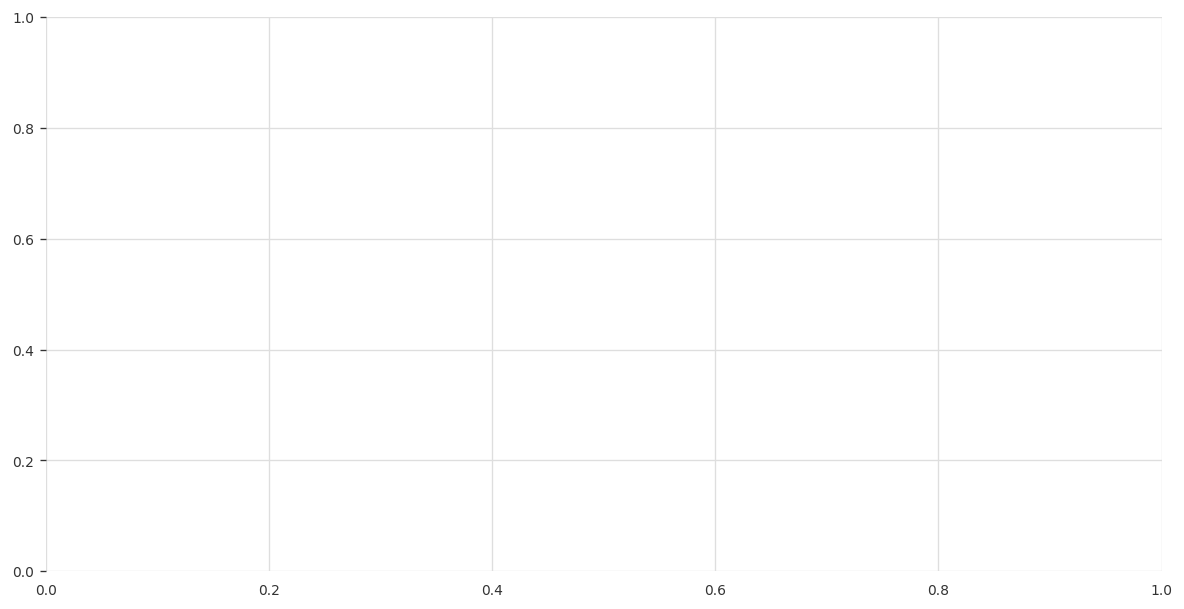

In [108]:
model = NaiveDrift()
model.fit(train_series)

forecast = model.predict(len(test_series))

mape_score = mape(test_series, forecast)

plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Données d\'entraînement', color='blue')
plt.plot(test_series, label='Données de test', color='green')
plt.plot(forecast, label='Prévisions Naive Drift (MAPE: {mape_score:.2f}%)', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Variable cible')
plt.title('Prévisions Naive Drift avec MAPE')
plt.show()

### Prophet

In [92]:
df_prophet

,ds,y
0,2013-01-01,5400.617021
1,2013-01-02,6428.812500
2,2013-01-03,6664.750000
3,2013-01-04,6666.875000
4,2013-01-05,6213.104167
...,...,...
3828,2023-06-26,4575.020833
3829,2023-06-27,4620.229167
3830,2023-06-28,4764.916667
3831,2023-06-29,4813.354167


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8946.004, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10591.456, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9257.128, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9381.244, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10616.542, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9013.783, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9071.404, Time=0.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8921.322, Time=4.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9001.465, Time=1.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8126.115, Time=5.37 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.49 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=8116.361, Time=9.78 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=8788.884, Time=5.42 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC

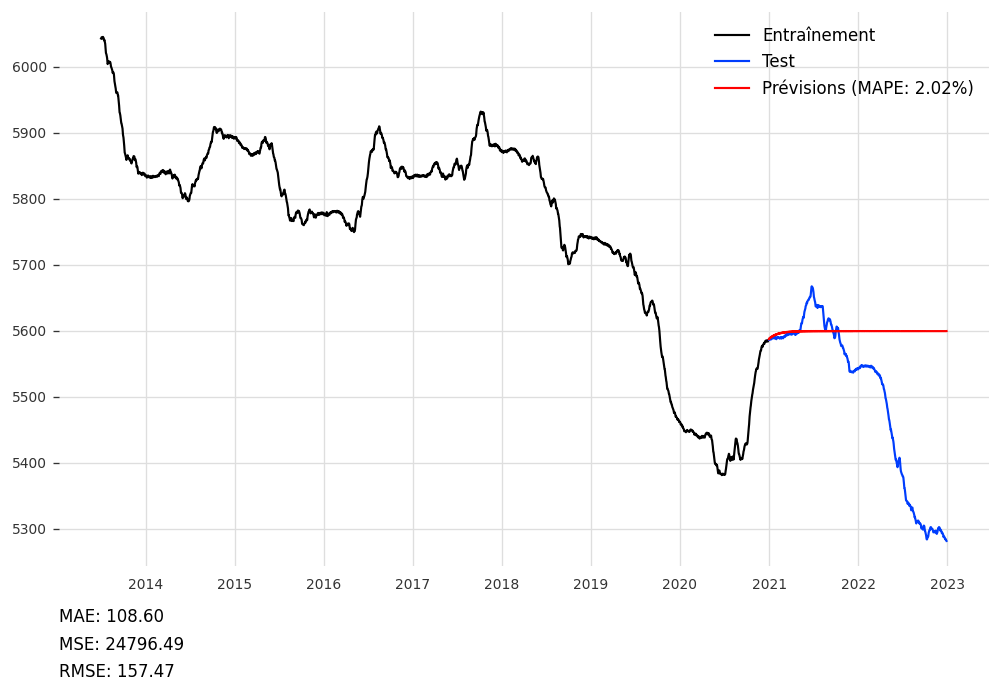

In [ ]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

df_diff = df_rolling_mean.dropna()

# Séparation en données d'entraînement et de test
training = df_diff.iloc[:-730]
test = df_diff.iloc[-730:]

# Utilisation de auto_arima pour trouver le meilleur modèle ARIMA
model = auto_arima(training, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(training)

# Faire une prévision
forecast = model.predict(n_periods=len(test))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculez le MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculez les erreurs
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

# Afficher la prévision
plt.figure(figsize=(10, 6))
plt.plot(training.index, training, label="Entraînement")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label=f'Prévisions (MAPE: {mape:.2f}%)', color='red')
plt.legend(loc='best')
leg = plt.gca().get_legend()
ltext = leg.get_texts()[0] # Obtenez le texte de la légende pour avoir sa position
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.15, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(ltext.get_position()[0], ltext.get_position()[1] - 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)
plt.show()

In [100]:
df_aggregated

date_heure
2012-12-31 00:00:00+00:00    5989.000000
2013-01-01 00:00:00+00:00    5412.687500
2013-01-02 00:00:00+00:00    6450.125000
2013-01-03 00:00:00+00:00    6668.416667
2013-01-04 00:00:00+00:00    6667.354167
                                ...     
2023-06-26 00:00:00+00:00    4589.083333
2023-06-27 00:00:00+00:00    4635.541667
2023-06-28 00:00:00+00:00    4759.458333
2023-06-29 00:00:00+00:00    4816.062500
2023-06-30 00:00:00+00:00    4656.227273
Freq: D, Name: consommation_brute_electricite_rte, Length: 3834, dtype: float64

In [101]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

train = df_aggregated.iloc[:-730]
test = df_aggregated.iloc[-730:]

X_train, y_train = train.drop(columns=['consommation_brute_electricite_rte']), train['consommation_brute_electricite_rte']
X_test, y_test = test.drop(columns=['consommation_brute_electricite_rte']), test['consommation_brute_electricite_rte']

model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Valeurs réelles', color='blue')
plt.plot(test.index, y_pred, label='Prédictions', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Variable cible')
plt.title('Prévisions XGBoost pour la série temporelle')
plt.show()

KeyError: 'consommation_brute_electricite_rte'

In [91]:
df_prophet.columns = ['ds', 'y']

In [95]:
from darts.models import Prophet

# Créez un objet modèle Prophet
model = Prophet()

# Ajustez le modèle aux données
model.fit(df_prophet)

# Prévoyez l'avenir
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Affichez le graphique des prévisions
fig = model.plot(forecast)


AttributeError: 'DataFrame' object has no attribute 'has_range_index'

In [94]:
import pandas as pd
from darts.models import Prophet
import matplotlib.pyplot as plt

# Différenciez la série temporelle
# df_diff = df_rolling_mean.dropna()

# Transformer les données pour Prophet
# df_prophet = df_prophet.reset_index()
df_prophet.columns = ['ds', 'y']

# Séparation en données d'entraînement et de test
training = df_prophet.iloc[:-365]
test = df_prophet.iloc[-365:]

# Instancier et entraîner un modèle Prophet
model = Prophet()
model.fit(training)

# Faire des prévisions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Tracer les résultats
plt.figure(figsize=(12, 6))
plt.plot(training['ds'], training['y'], label='Entraînement', color='blue')
plt.plot(test['ds'], test['y'], label='Test', color='green')
plt.plot(forecast['ds'], forecast['yhat'], label='Prévisions', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.legend()
plt.title('Prévisions avec Prophet')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'has_range_index'

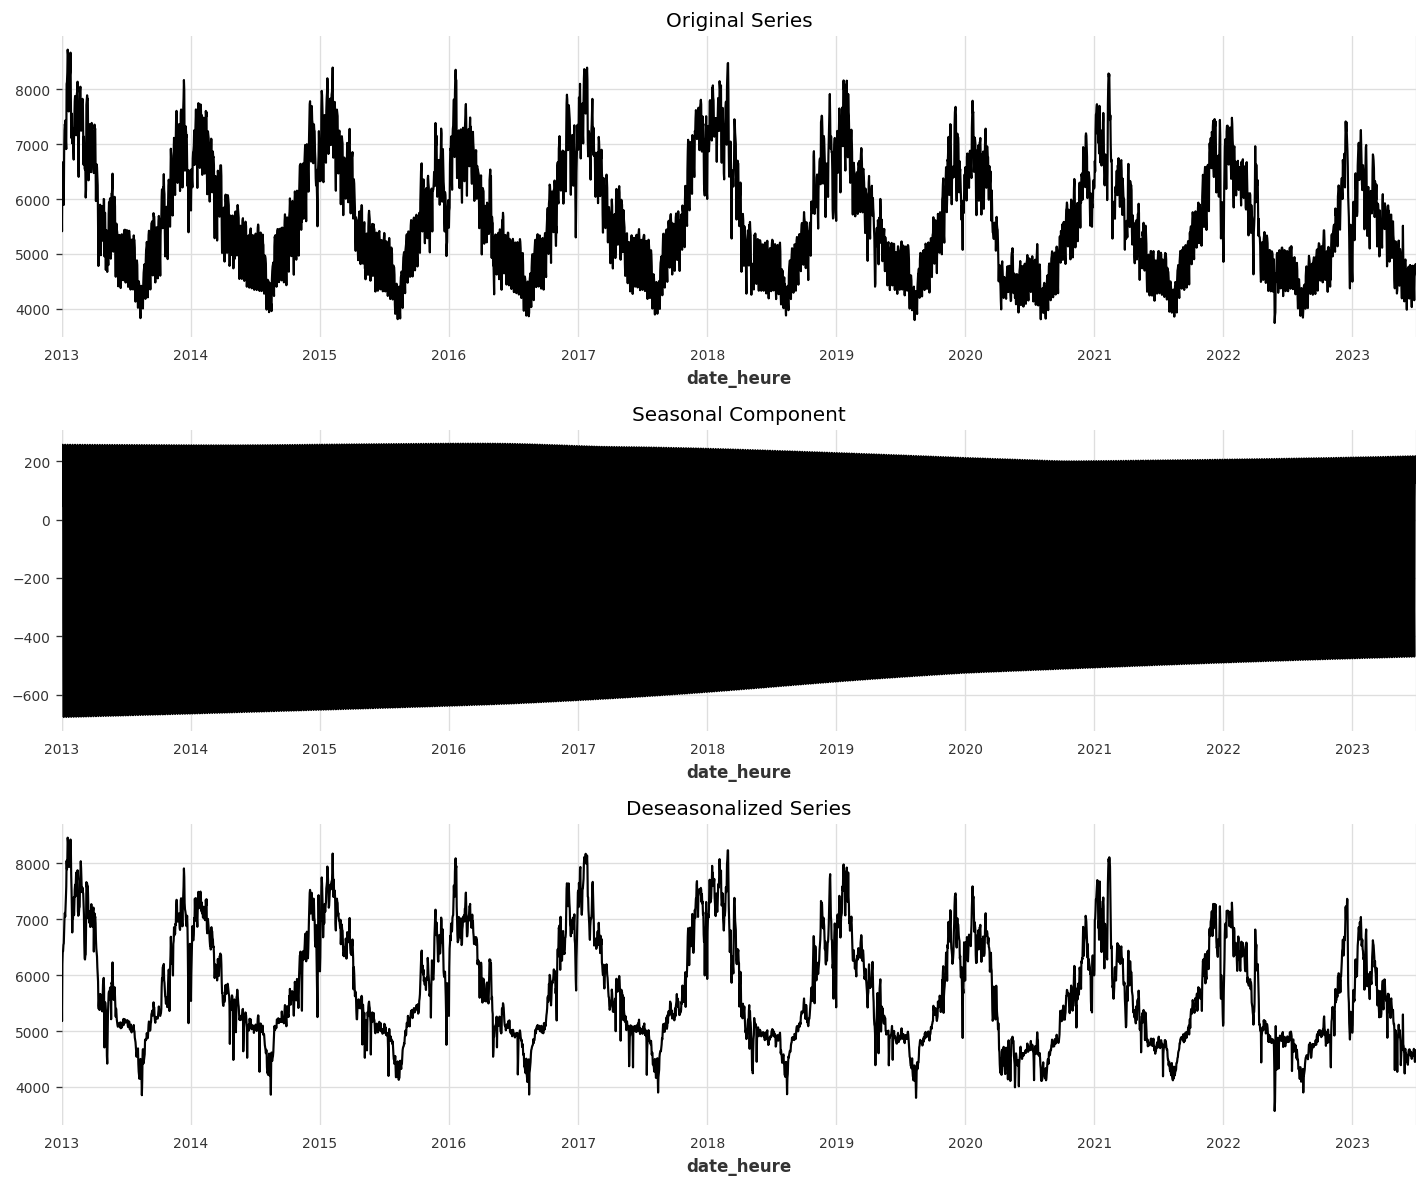

In [52]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Décomposition STL de la série
stl_result = sm.tsa.STL(df_daily, seasonal=365).fit()

# Obtenez la composante saisonnière
seasonal = stl_result.seasonal

# Désaisonnalisez la série
df_deseasonalized = df_daily - seasonal

# Afficher les résultats
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
df_daily.plot(ax=ax[0], title='Original Series')
seasonal.plot(ax=ax[1], title='Seasonal Component')
df_deseasonalized.plot(ax=ax[2], title='Deseasonalized Series')
plt.tight_layout()
plt.show()
